In [1]:
import logging
import time

import numpy as np
import matplotlib.pyplot as plt

# import tensorflow_datasets as tfds
import tensorflow as tf
# import tensorflow_text

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchinfo as ti
import torchsummary as ts

# 사전 변수를 오브젝트 변수로
from attrdict import AttrDict

In [2]:
config = {'head_num':8, 
          'd_model':512, 
          'd_ff':2048, 
          'max_position_embeddings':2048, 
          'hidden_dropout_prob':0.1,
          'encoder_layer':6, 
          'decoder_layer':6,
          'layer_norm_eps': 1e-5,
          'vocab_size':30000}

config = AttrDict(config)

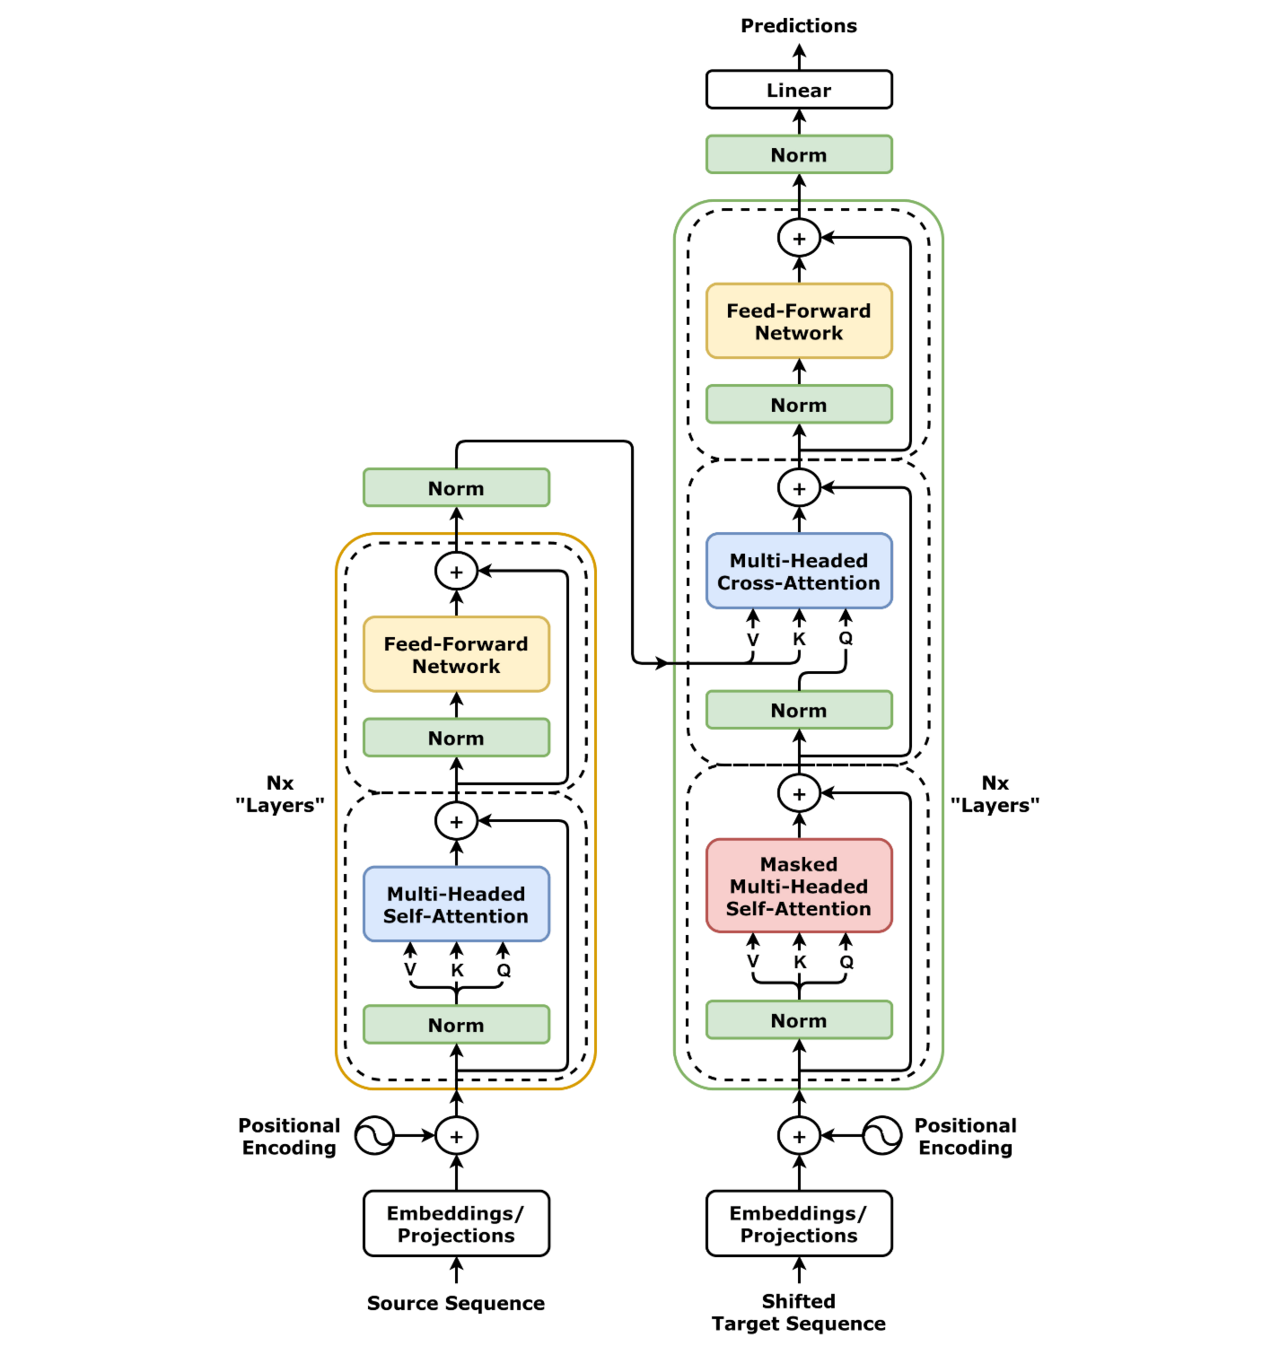

In [3]:
config

AttrDict({'head_num': 8, 'd_model': 512, 'd_ff': 2048, 'max_position_embeddings': 2048, 'hidden_dropout_prob': 0.1, 'encoder_layer': 6, 'decoder_layer': 6, 'layer_norm_eps': 1e-05, 'vocab_size': 30000})

In [4]:
def positional_encoding(config):
    
    depth = config.d_model
    length = config.max_position_embeddings
    
    # 각 위치에 대한 인덱스 생성
    positions = np.arange(length)[:, np.newaxis]          # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :] / depth  # (1, depth)

    # 각 깊이에 대한 각도 비율 계산
    angle_rates = 1 / (10000 ** depths)          # (1, depth)
    angle_rads = positions * angle_rates        # (pos, depth)

    # sin과 cos을 사용하여 위치 인코딩 생성
    sin = torch.from_numpy(np.sin(angle_rads)).to(torch.float32)
    cos = torch.from_numpy(np.cos(angle_rads)).to(torch.float32)

    # (pos, depth)
    pos_embedding = torch.zeros((config.max_position_embeddings, config.d_model))
    
    # sin은 짝수 인덱스, cos은 홀수 인덱스만을 쓰기 위함
    even_index = np.arange(config.max_position_embeddings) % 2 == 0
    odd_index = ~even_index
    
    pos_embedding[even_index] = sin[even_index]
    pos_embedding[odd_index] = cos[odd_index]

    return pos_embedding

torch.Size([2048, 512])


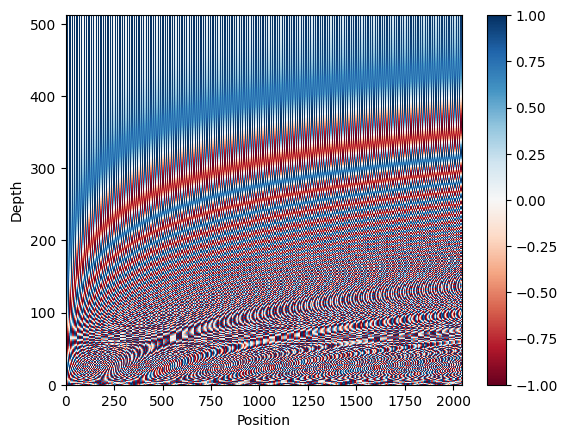

In [5]:
# 위치 인코딩 생성
pos_encoding = positional_encoding(config)

# 생성된 위치 인코딩의 형상 확인
print(pos_encoding.shape)  # (2048, 512)

# 위치 인코딩 시각화
plt.pcolormesh(pos_encoding.numpy().T, cmap='RdBu')  # 깊이에 따른 위치 인코딩 시각화
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()  # 컬러바 추가
plt.show()

In [9]:
#positional_encoding 함수는 길이가 2048, 깊이가 512인 위치 인코딩 행렬을 생성합니다.
class PositionalEmbedding(nn.Module):
    def __init__(self, config):
        super(PositionalEmbedding, self).__init__()
        self.config = config
        self.embedding = nn.Embedding(config.vocab_size, config.d_model, padding_idx=0)
        self.pos_encoding = positional_encoding(config)

    def compute_mask(self, *args, **kwargs):
        # 마스크 계산 (패딩된 부분을 모델이 무시하도록 함)
        return self.embedding.compute_mask(*args, **kwargs)

    def forward(self, x):
        seq = self.config.max_position_embeddings    # 입력 시퀀스의 길이
        token_embeddings = self.embedding(x)    # 단어 임베딩 적용
        token_embeddings *= np.sqrt(self.config.d_model, dtype=np.float32) # 임베딩 크기 조정
        # x = x + self.pos_encoding[tf.newaxis, :length, :]     # 위치 인코딩 추가
        positional_embeddings = self.pos_encoding
        embedding = token_embeddings + positional_embeddings
        
        return embedding

In [20]:
tensor = torch.randint(0, 30000, size=(2, 2048))
tensor.shape, tensor

(torch.Size([2, 2048]),
 tensor([[22941, 14523,  7091,  ..., 24730,  4002, 26756],
         [16565, 17630, 19287,  ..., 12246,  1846,  6627]]))

In [22]:
# tensor.size(1)
# batch, seq, embedding
pos_model = PositionalEmbedding(config)
embedding = pos_model(tensor)
embedding.shape

torch.Size([2, 2048, 512])

In [23]:
embedding

tensor([[[-2.4021e+00,  9.2905e-01, -6.4355e+00,  ...,  4.1033e+00,
           1.6915e+01, -3.2855e+01],
         [-1.8162e+00,  3.8321e+00,  1.2457e+01,  ...,  1.1770e+01,
           1.6572e+01, -2.8534e+01],
         [-1.7384e+01, -1.1854e+01,  2.0319e+01,  ..., -2.2329e+01,
           1.5721e+01, -1.5008e+01],
         ...,
         [-1.8439e+01,  2.8162e+01,  2.3185e+01,  ...,  2.1501e+01,
           1.1875e+00,  1.2348e+01],
         [-1.3164e+01, -4.1267e+00, -7.0507e+00,  ...,  9.2946e+00,
          -1.8691e+01, -1.7173e+01],
         [ 1.3176e+01, -3.4891e-01, -1.9548e+01,  ...,  9.2329e+00,
          -2.0974e+01, -8.3481e+00]],

        [[-1.0345e+01, -1.3151e+01,  4.8717e+00,  ...,  1.7427e+00,
          -2.4811e+01,  1.6021e-01],
         [ 3.4863e+01,  4.8367e+01,  4.0950e+00,  ..., -1.7776e+01,
           1.2001e+01,  1.1964e+01],
         [ 1.6833e-02, -6.2867e+00, -1.9271e+01,  ...,  1.9756e+01,
          -1.5731e+01,  2.1585e+01],
         ...,
         [ 2.3173e+01,  7

In [26]:
d_model = config.d_model
seq = config.max_position_embeddings
positional_encoding(config)[torch.newaxis, :seq, :].shape

torch.Size([1, 2048, 512])

## Encoder

Encoder: The encoder is composed of a stack of N = 6 identical layers. Each layer has two
sub-layers. The first is a multi-head self-attention mechanism, and the second is a simple, position
wise fully connected feed-forward network. We employ a residual connection [10] around each of
the two sub-layers, followed by layer normalization [1]. That is, the output of each sub-layer is
LayerNorm(x + Sublayer(x)), where Sublayer(x) is the function implemented by the sub-layer
itself. To facilitate these residual connections, all sub-layers in the model, as well as the embedding
layers, produce outputs of dimension dmodel = 512.

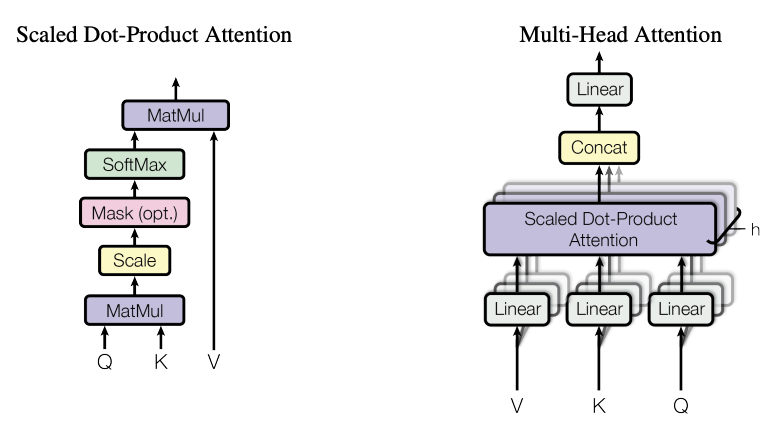

In [27]:
attention_head_size = int(config.d_model / config.head_num)
all_head_size = config.head_num * attention_head_size
attention_head_size, all_head_size

(64, 512)

In [28]:
class MultiHeadAttn(nn.Module):
    def __init__(self, config):
        super().__init__()
        
        self.config = config
        
        self.d_model = config.d_model
        self.max_position_embeddings = config.max_position_embeddings
        self.head_num = config.head_num
        
        self.attention_head_size = int(config.d_model / config.head_num)
        self.all_head_size = config.head_num * self.attention_head_size

        self.query = nn.Linear(config.d_model, self.all_head_size, bias=True)
        self.key = nn.Linear(config.d_model, self.all_head_size, bias=True)
        self.value = nn.Linear(config.d_model, self.all_head_size, bias=True)

        self.dropout = nn.Dropout(p=config.hidden_dropout_prob)
        
    def to_multi_head(self, layer):
        return layer.view(layer.size()[:1][0], self.config.head_num, self.config.max_position_embeddings, self.attention_head_size)
        
    def forward(self, input_tensor, token_type_ids = None):
        
        query_layer = self.query(input_tensor)
        key_layer = self.key(input_tensor)
        value_layer = self.value(input_tensor)
        
        # print('query layer shape : {}'.format(query_layer.shape))
        # print('key layer shape : {}'.format(key_layer.shape))
        # print('value layer shape : {}'.format(value_layer.shape))
        
        multi_query_layer = self.to_multi_head(query_layer)
        multi_key_layer = self.to_multi_head(key_layer)
        multi_value_layer = self.to_multi_head(value_layer)
  
        # print('multi query layer shape : {}'.format(multi_query_layer.shape))
        # print('multi key layer shape : {}'.format(multi_key_layer.shape))
        # print('multi value layer shape : {}'.format(multi_value_layer.shape))
        
        matmul = multi_query_layer @ multi_key_layer.transpose(2, 3)
        
        matmul /= np.sqrt(self.config.d_model // self.config.head_num)
        # mask(opt) pass, padding 큰 음수 주기
        attn_score = nn.Softmax(dim=-1)(matmul)
        
        attn_score = self.dropout(attn_score)
        # print('attn score shape : {}'.format(attn_score.shape))
        
        attn_score = attn_score @ multi_value_layer
        attn_score = attn_score.view(input_tensor.size()[:1][0], self.config.max_position_embeddings, self.config.d_model)
        
        return attn_score

In [29]:
d_model = config.d_model

pos = PositionalEmbedding(config)

batch = tensor.size(0)
seq = tensor.size(1)

input_ids = pos(tensor)
scaled_dot_pro = MultiHeadAttn(config)
scaled_dot_pro

MultiHeadAttn(
  (query): Linear(in_features=512, out_features=512, bias=True)
  (key): Linear(in_features=512, out_features=512, bias=True)
  (value): Linear(in_features=512, out_features=512, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [30]:
hidden_states = scaled_dot_pro(embedding)
embedding.shape, hidden_states.shape

(torch.Size([2, 2048, 512]), torch.Size([2, 2048, 512]))

In [31]:
class AddNorm(nn.Module):
    def __init__(self, config):
        super().__init__()
        
        self.LayerNorm = nn.LayerNorm(config.d_model, eps=config.layer_norm_eps)
        
    def forward(self, original_tensor, hidden_states):
        
        return self.LayerNorm(original_tensor + hidden_states)

In [32]:
add_norm = AddNorm(config)
addnorm_hidden_states = add_norm(hidden_states, embedding)
addnorm_hidden_states.shape

torch.Size([2, 2048, 512])

In [33]:
class FFNN(nn.Module):
    def __init__(self, config):
        super().__init__()
        
        self.linear1 = nn.Linear(config.d_model, config.d_ff, bias=True)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(config.d_ff, config.d_model, bias=True)
        
    def forward(self, hidden_states):
        
        hidden_states = self.linear1(hidden_states)
        hidden_states = self.relu(hidden_states)
        hidden_states = self.linear2(hidden_states)
        
        return hidden_states

In [34]:
d_model = config.d_model
d_ff = config.d_ff
ffnn = FFNN(config)
hidden_states = ffnn(addnorm_hidden_states)
hidden_states.shape

torch.Size([2, 2048, 512])

In [35]:
hidden_states = add_norm(hidden_states, addnorm_hidden_states)
hidden_states.shape

torch.Size([2, 2048, 512])

In [36]:
class EncoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        
        self.config = config
        
        self.mha = MultiHeadAttn(config)
        self.middle_add_norm = AddNorm(config)
        self.ffnn = FFNN(config)
        self.out_add_norm = AddNorm(config)
    
    def forward(self, input_ids):
        
        hidden_states = self.mha(input_ids)
        hidden_states = self.middle_add_norm(input_ids, hidden_states)
        ffnn_hidden_states = self.ffnn(hidden_states)
        output = self.out_add_norm(hidden_states, ffnn_hidden_states)
        
        return output

In [37]:
encoderlayer = EncoderLayer(config)
result = encoderlayer(embedding)
result.shape

torch.Size([2, 2048, 512])

In [38]:
class Encoder(nn.Module):
    def __init__(self, config):
        super(Encoder, self).__init__()
        
        self.embedding = PositionalEmbedding(config)
        self.encoder = nn.ModuleList([EncoderLayer(config) for _ in range(config.encoder_layer)])
        
    def forward(self, input_ids):
        
        save_hidden_states = []
        
        hidden_states = self.embedding(input_ids)
        
        for layer in self.encoder:
            hidden_states = layer(hidden_states)
        
            save_hidden_states.append(hidden_states)
            
        return hidden_states

In [39]:
encoder = Encoder(config)
encoder

Encoder(
  (embedding): PositionalEmbedding(
    (embedding): Embedding(30000, 512, padding_idx=0)
  )
  (encoder): ModuleList(
    (0-5): 6 x EncoderLayer(
      (mha): MultiHeadAttn(
        (query): Linear(in_features=512, out_features=512, bias=True)
        (key): Linear(in_features=512, out_features=512, bias=True)
        (value): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (middle_add_norm): AddNorm(
        (LayerNorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      )
      (ffnn): FFNN(
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (relu): ReLU()
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
      )
      (out_add_norm): AddNorm(
        (LayerNorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      )
    )
  )
)

In [40]:
embedding.shape

torch.Size([2, 2048, 512])

In [41]:
tensor.shape

torch.Size([2, 2048])

In [42]:
encoder_output = encoder(tensor)
encoder_output.shape

torch.Size([2, 2048, 512])

In [43]:
ti.summary(encoder)

Layer (type:depth-idx)                   Param #
Encoder                                  --
├─PositionalEmbedding: 1-1               --
│    └─Embedding: 2-1                    15,360,000
├─ModuleList: 1-2                        --
│    └─EncoderLayer: 2-2                 --
│    │    └─MultiHeadAttn: 3-1           787,968
│    │    └─AddNorm: 3-2                 1,024
│    │    └─FFNN: 3-3                    2,099,712
│    │    └─AddNorm: 3-4                 1,024
│    └─EncoderLayer: 2-3                 --
│    │    └─MultiHeadAttn: 3-5           787,968
│    │    └─AddNorm: 3-6                 1,024
│    │    └─FFNN: 3-7                    2,099,712
│    │    └─AddNorm: 3-8                 1,024
│    └─EncoderLayer: 2-4                 --
│    │    └─MultiHeadAttn: 3-9           787,968
│    │    └─AddNorm: 3-10                1,024
│    │    └─FFNN: 3-11                   2,099,712
│    │    └─AddNorm: 3-12                1,024
│    └─EncoderLayer: 2-5                 --
│    │   

In [33]:
# ts.summary(encoder, input_size=(2, 2048))

## Decoder

Decoder: The decoder is also composed of a stack of N = 6 identical layers. In addition to the two
sub-layers in each encoder layer, the decoder inserts a third sub-layer, which performs multi-head
attention over the output of the encoder stack. Similar to the encoder, we employ residual connections
around each of the sub-layers, followed by layer normalization. We also modify the self-attention
sub-layer in the decoder stack to prevent positions from attending to subsequent positions. This
masking, combined with fact that the output embeddings are offset by one position, ensures that the
predictions for position i can depend only on the known outputs at positions less than i.

In [44]:
class CrossSelfAttn(nn.Module):
    def __init__(self, config):
        super(CrossSelfAttn, self).__init__()
        
        self.config = config
        
        self.attention_head_size = int(config.d_model / config.head_num)
        self.all_head_size = config.head_num * self.attention_head_size
        
        self.query = nn.Linear(config.d_model, self.all_head_size, bias=True)
        self.key = nn.Linear(config.d_model, self.all_head_size, bias=True)
        self.value = nn.Linear(config.d_model, self.all_head_size, bias=True)
        
        self.dropout = nn.Dropout(p=0.1)
        
    def to_multi_head(self, layer):
        return layer.view(layer.size()[:1][0], self.config.head_num, self.config.max_position_embeddings, self.attention_head_size)
        
    def forward(self, encoder_input_ids, decoder_input_ids):
        
        # query, key from encoder output
        # value from decoder output
        query_layer = self.query(encoder_input_ids)
        key_layer = self.key(encoder_input_ids)
        value_layer = self.value(decoder_input_ids)
        
        multi_query_layer = self.to_multi_head(query_layer)
        multi_key_layer = self.to_multi_head(key_layer)
        multi_value_layer = self.to_multi_head(value_layer)
        
        matmul = multi_query_layer @ multi_key_layer.transpose(2, 3)
        
        matmul /= np.sqrt(self.config.d_model // config.head_num)
        # mask(opt) pass, padding 큰 음수 주기
        attn_score = nn.Softmax(dim=-1)(matmul)
        
        attn_score = self.dropout(attn_score)
        # print('attn score shape : {}'.format(attn_score.shape))
        
        attn_score = attn_score @ multi_value_layer
        attn_score = attn_score.view(encoder_input_ids.size()[:1][0], self.config.max_position_embeddings, self.config.d_model)
        
        return attn_score

In [45]:
cross_attn = CrossSelfAttn(config)
output = cross_attn(encoder_input_ids=encoder_output, decoder_input_ids=encoder_output)
output.shape

torch.Size([2, 2048, 512])

In [46]:
class MaskedSelfAttn(nn.Module):
    def __init__(self, config):
        super(MaskedSelfAttn, self).__init__()
        
        self.config = config
        
        self.attention_head_size = int(config.d_model / config.head_num)
        self.all_head_size = config.head_num * self.attention_head_size
        
        self.query = nn.Linear(config.d_model, self.all_head_size, bias=True)
        self.key = nn.Linear(config.d_model, self.all_head_size, bias=True)
        self.value = nn.Linear(config.d_model, self.all_head_size, bias=True)
        
        self.dropout = nn.Dropout(p=0.1)
        
    def to_multi_head(self, layer):
        return layer.view(layer.size()[:1][0], self.config.head_num, self.config.max_position_embeddings, self.attention_head_size)
        
    def forward(self, hidden_states):
        
        query_layer = self.query(hidden_states)
        key_layer = self.key(hidden_states)
        value_layer = self.value(hidden_states)
        
        multi_query_layer = self.to_multi_head(query_layer)
        multi_key_layer = self.to_multi_head(key_layer)
        multi_value_layer = self.to_multi_head(value_layer)
        
        matmul = multi_query_layer @ multi_key_layer.transpose(2, 3)
        
        matmul /= np.sqrt(self.config.d_model // config.head_num)
        # mask(opt) pass, padding 큰 음수 주기
        
        # softmax 하기전 masked진행
        seq_len = matmul.size(-1)  # Sequence length (2048)
        causal_mask = torch.triu(torch.ones(config.max_position_embeddings, config.max_position_embeddings), diagonal=1).bool()  # Upper triangular mask
        causal_mask = causal_mask.unsqueeze(0).unsqueeze(1)  # [1, 1, Seq_Len, Seq_Len]
        # mask 적용
        masked_attention_scores = matmul.masked_fill(causal_mask, float('-inf'))
        
        attn_score = nn.Softmax(dim=-1)(masked_attention_scores)
        
        attn_score = self.dropout(attn_score)
        # print('attn score shape : {}'.format(attn_score.shape))
        
        attn_score = attn_score @ multi_value_layer
        attn_score = attn_score.view(hidden_states.size()[:1][0], self.config.max_position_embeddings, self.config.d_model)
        
        return attn_score

In [47]:
masked_attn = MaskedSelfAttn(config)
masked_attn

MaskedSelfAttn(
  (query): Linear(in_features=512, out_features=512, bias=True)
  (key): Linear(in_features=512, out_features=512, bias=True)
  (value): Linear(in_features=512, out_features=512, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [48]:
result_output = masked_attn(encoder_output)
result_output.shape

torch.Size([2, 2048, 512])

In [49]:
class DecoderLayer(nn.Module):
    def __init__(self, config):
        super(DecoderLayer, self).__init__()
        
        self.maskedattn = MaskedSelfAttn(config)
        self.addnorm1 = AddNorm(config)
        self.crossattn = CrossSelfAttn(config)
        self.addnorm2 = AddNorm(config)
        self.ffnn = FFNN(config)
        self.addnorm3 = AddNorm(config)
        
    def forward(self, encoder_output, decoder_embedding):
        
        # masked_self_attn + [add + norm]
        decoder_hidden_states = self.maskedattn(decoder_embedding)
        decoder_hidden_states = self.addnorm1(decoder_embedding, decoder_hidden_states)

        # cross_self_attn + [add + norm]
        cross_hidden_states = self.crossattn(encoder_output, decoder_hidden_states)
        cross_addnorm_hidden_states = self.addnorm2(decoder_hidden_states, cross_hidden_states)
        
        # feed_forward_neural_network + [add + norm]
        decoder_hidden_states = self.ffnn(cross_addnorm_hidden_states)
        hidden_states = self.addnorm3(cross_addnorm_hidden_states, decoder_hidden_states)
        
        return hidden_states

In [50]:
decoderlayer = DecoderLayer(config)
decoderlayer

DecoderLayer(
  (maskedattn): MaskedSelfAttn(
    (query): Linear(in_features=512, out_features=512, bias=True)
    (key): Linear(in_features=512, out_features=512, bias=True)
    (value): Linear(in_features=512, out_features=512, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (addnorm1): AddNorm(
    (LayerNorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (crossattn): CrossSelfAttn(
    (query): Linear(in_features=512, out_features=512, bias=True)
    (key): Linear(in_features=512, out_features=512, bias=True)
    (value): Linear(in_features=512, out_features=512, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (addnorm2): AddNorm(
    (LayerNorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (ffnn): FFNN(
    (linear1): Linear(in_features=512, out_features=2048, bias=True)
    (relu): ReLU()
    (linear2): Linear(in_features=2048, out_features=512, bias=True)
  )
  (addnorm3): AddNorm(
    (LayerNorm): LayerNorm((512,), eps

In [51]:
decoderlayer(encoder_output=encoder_output, decoder_embedding=encoder_output).shape

torch.Size([2, 2048, 512])

In [52]:
class Decoder(nn.Module):
    def __init__(self, config):
        super(Decoder, self).__init__()
        
        self.embedding = PositionalEmbedding(config)
        self.encoder = nn.ModuleList([DecoderLayer(config) for _ in range(config.decoder_layer)])
        
    def forward(self, encoder_output, input_ids):
        
        save_hidden_states = []
        
        hidden_states = self.embedding(input_ids)
        
        for layer in self.encoder:
            hidden_states = layer(encoder_output, hidden_states)
        
            save_hidden_states.append(hidden_states)
            
        return hidden_states

In [53]:
decoder = Decoder(config)
decoder

Decoder(
  (embedding): PositionalEmbedding(
    (embedding): Embedding(30000, 512, padding_idx=0)
  )
  (encoder): ModuleList(
    (0-5): 6 x DecoderLayer(
      (maskedattn): MaskedSelfAttn(
        (query): Linear(in_features=512, out_features=512, bias=True)
        (key): Linear(in_features=512, out_features=512, bias=True)
        (value): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (addnorm1): AddNorm(
        (LayerNorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      )
      (crossattn): CrossSelfAttn(
        (query): Linear(in_features=512, out_features=512, bias=True)
        (key): Linear(in_features=512, out_features=512, bias=True)
        (value): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (addnorm2): AddNorm(
        (LayerNorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      )
      (ffnn): FFNN(
   

In [54]:
class Transformer(nn.Module):
    def __init__(self, config):
        super(Transformer, self).__init__()
            
        self.encoder = Encoder(config)
        self.decoder = Decoder(config)
        
        self.linear = nn.Linear(config.d_model, config.vocab_size, bias=True)
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, input_ids, output_ids):
        
        encoder_output = self.encoder(input_ids)
        decoder_output = self.decoder(encoder_output, output_ids)
        
        output = self.linear(decoder_output)
        output = self.softmax(output)
        
        return output

In [55]:
model = Transformer(config)

In [56]:
model

Transformer(
  (encoder): Encoder(
    (embedding): PositionalEmbedding(
      (embedding): Embedding(30000, 512, padding_idx=0)
    )
    (encoder): ModuleList(
      (0-5): 6 x EncoderLayer(
        (mha): MultiHeadAttn(
          (query): Linear(in_features=512, out_features=512, bias=True)
          (key): Linear(in_features=512, out_features=512, bias=True)
          (value): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (middle_add_norm): AddNorm(
          (LayerNorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        )
        (ffnn): FFNN(
          (linear1): Linear(in_features=512, out_features=2048, bias=True)
          (relu): ReLU()
          (linear2): Linear(in_features=2048, out_features=512, bias=True)
        )
        (out_add_norm): AddNorm(
          (LayerNorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
  )
  (decoder): Decoder(
    (embeddi

In [57]:
ti.summary(model)

Layer (type:depth-idx)                        Param #
Transformer                                   --
├─Encoder: 1-1                                --
│    └─PositionalEmbedding: 2-1               --
│    │    └─Embedding: 3-1                    15,360,000
│    └─ModuleList: 2-2                        --
│    │    └─EncoderLayer: 3-2                 2,889,728
│    │    └─EncoderLayer: 3-3                 2,889,728
│    │    └─EncoderLayer: 3-4                 2,889,728
│    │    └─EncoderLayer: 3-5                 2,889,728
│    │    └─EncoderLayer: 3-6                 2,889,728
│    │    └─EncoderLayer: 3-7                 2,889,728
├─Decoder: 1-2                                --
│    └─PositionalEmbedding: 2-3               --
│    │    └─Embedding: 3-8                    15,360,000
│    └─ModuleList: 2-4                        --
│    │    └─DecoderLayer: 3-9                 3,678,720
│    │    └─DecoderLayer: 3-10                3,678,720
│    │    └─DecoderLayer: 3-11           

In [58]:
# 동작테스트
result = model(tensor, tensor)
result.shape, result

(torch.Size([2, 2048, 30000]),
 tensor([[[4.0468e-05, 3.5965e-05, 4.4903e-05,  ..., 3.3070e-05,
           2.9336e-05, 4.3177e-05],
          [3.8502e-05, 4.7534e-05, 8.4482e-05,  ..., 2.2189e-05,
           1.2476e-05, 2.3329e-05],
          [3.5030e-05, 2.2306e-05, 4.3148e-05,  ..., 4.0970e-05,
           3.4781e-05, 7.9944e-06],
          ...,
          [1.9654e-05, 4.7801e-05, 9.3675e-06,  ..., 1.9303e-05,
           3.5749e-05, 1.9267e-05],
          [1.2777e-05, 1.4126e-05, 1.1565e-05,  ..., 2.0629e-05,
           2.9504e-05, 2.6434e-05],
          [1.3850e-05, 1.1501e-04, 1.8504e-05,  ..., 1.1848e-05,
           3.4261e-05, 2.5864e-05]],
 
         [[1.2940e-05, 4.1959e-05, 2.3979e-05,  ..., 3.5756e-05,
           1.7751e-05, 6.9784e-05],
          [5.4781e-05, 6.5626e-05, 1.4674e-05,  ..., 2.8667e-05,
           1.3383e-05, 1.5585e-05],
          [4.3333e-05, 3.1046e-05, 2.1186e-05,  ..., 2.5414e-05,
           2.3308e-05, 4.2373e-05],
          ...,
          [4.3933e-05, 3.14